In [3]:
import os
import time

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import scipy

from pymc3.gp.util import plot_gp_dist

import pyro
import pyro.contrib.gp as gp
import pyro.distributions as dist
import torch

from tqdm import tqdm

In [4]:
# Don't sting my eyes
%config InlineBackend.figure_format = 'retina'
sns.set()

# Utility models

In [5]:
def u_pow(x, theta): return x**theta[0]

In [6]:
def u_exp(x, theta): return 1 - np.exp(-theta[0]*x)

# Generate choice data

In [7]:
def generate_data(u, seed=123, max_x=1, n=100, tau=3.333, theta=(0.5, )):
    
    np.random.seed(seed)
    
    data = pd.DataFrame(np.random.uniform(0, 1, size=(n*10, 4)), columns=["p0", "x0", "p1", "x1"])
    for i in range(2):
        data[f"x{i}"] = data[f"x{i}"].values * max_x
    data = data[~((data.p0 >= data.p1) & (data.x0 >= data.x1))]
    data = data[~((data.p1 >= data.p0) & (data.x1 >= data.x0))]
    data = data.sample(n=n, replace=False)
    
    p0 = data.p0.values
    p1 = data.p1.values
    x0 = data.x0.values
    x1 = data.x1.values
    
    seu0 = p0 * u(x0, theta)
    seu1 = p1 * u(x1, theta)

    diff_eu = seu1 - seu0

    p_choice_1 = scipy.special.expit(tau*diff_eu)
    choices = np.zeros(n, dtype=int)
    choices[:] = p_choice_1 > np.random.random(size=n)
    data['choices'] = choices

    return data

In [8]:
data = generate_data(u=u_pow, n=1000, tau=3.333, theta=(0.5, ))
data

,p0,x0,p1,x1,choices
9002,0.696389,0.007647,0.617248,0.282997,1
7863,0.953285,0.292898,0.380948,0.552913,1
7455,0.060678,0.327938,0.685627,0.158464,1
3414,0.138550,0.276750,0.788651,0.125342,0
5796,0.116159,0.356232,0.732859,0.310642,0
...,...,...,...,...,...
2857,0.928569,0.159319,0.006656,0.571188,0
5417,0.621396,0.103035,0.601608,0.871169,1
1854,0.218694,0.560962,0.389658,0.026879,1
8834,0.980679,0.073375,0.877985,0.777087,1


# Likelihood whole model given M, $\theta_M$

In [9]:
def softplus(x):
    return np.log(1 + np.exp(x))

def objective(param, data, u_m):
    
    param = softplus(param)  # All parameters all supposed to be R+
    
    tau = param[0]
    theta = param[1:]
    
    p0 = data.p0.values
    p1 = data.p1.values
    x0 = data.x0.values
    x1 = data.x1.values
    y = data.choices.values 
    
    seu0 = p0 * u_m(x0, theta)
    seu1 = p1 * u_m(x1, theta)

    diff_eu = seu1 - seu0

    p_choice_1 = scipy.special.expit(tau*diff_eu) # p choose 1
    p_choice_y = p_choice_1**y * (1-p_choice_1)**(1-y)
    return - np.log(p_choice_y).sum()

In [10]:
def optimize(data, u_m=u_pow, x0=None):
    if x0 is None:
        x0 = (0.0, 0.0) # Assume two parameters
    opt = scipy.optimize.minimize(objective, x0=x0, args=(data, u_m))
    return softplus(opt.x)

In [11]:
optimize(data, u_m=u_pow)

array([3.28496491, 0.53506426])

# Measure discrepancy

In [12]:
from torch.distributions import constraints
from torch.nn import Parameter

import pyro
import pyro.distributions as dist
import pyro.poutine as poutine
from pyro.contrib.gp.util import conditional
from pyro.distributions.util import eye_like
from pyro.nn.module import PyroParam, pyro_method

from pyro.contrib.gp.parameterized import Parameterized

In [13]:
def _zero_mean_function(x):
    return 0


class GPModel(Parameterized):
    r"""
    Base class for Gaussian Process models.
    The core of a Gaussian Process is a covariance function :math:`k` which governs
    the similarity between input points. Given :math:`k`, we can establish a
    distribution over functions :math:`f` by a multivarite normal distribution
    .. math:: p(f(X)) = \mathcal{N}(0, k(X, X)),
    where :math:`X` is any set of input points and :math:`k(X, X)` is a covariance
    matrix whose entries are outputs :math:`k(x, z)` of :math:`k` over input pairs
    :math:`(x, z)`. This distribution is usually denoted by
    .. math:: f \sim \mathcal{GP}(0, k).
    .. note:: Generally, beside a covariance matrix :math:`k`, a Gaussian Process can
        also be specified by a mean function :math:`m` (which is a zero-value function
        by default). In that case, its distribution will be
        .. math:: p(f(X)) = \mathcal{N}(m(X), k(X, X)).
    Gaussian Process models are :class:`~pyro.contrib.gp.util.Parameterized`
    subclasses. So its parameters can be learned, set priors, or fixed by using
    corresponding methods from :class:`~pyro.contrib.gp.util.Parameterized`. A typical
    way to define a Gaussian Process model is
        >>> X = torch.tensor([[1., 5, 3], [4, 3, 7]])
        >>> y = torch.tensor([2., 1])
        >>> kernel = gp.kernels.RBF(input_dim=3)
        >>> kernel.variance = pyro.nn.PyroSample(dist.Uniform(torch.tensor(0.5), torch.tensor(1.5)))
        >>> kernel.lengthscale = pyro.nn.PyroSample(dist.Uniform(torch.tensor(1.0), torch.tensor(3.0)))
        >>> gpr = gp.models.GPRegression(X, y, kernel)
    There are two ways to train a Gaussian Process model:
    + Using an MCMC algorithm (in module :mod:`pyro.infer.mcmc`) on :meth:`model` to
      get posterior samples for the Gaussian Process's parameters. For example:
        >>> hmc_kernel = HMC(gpr.model)
        >>> mcmc = MCMC(hmc_kernel, num_samples=10)
        >>> mcmc.run()
        >>> ls_name = "kernel.lengthscale"
        >>> posterior_ls = mcmc.get_samples()[ls_name]
    + Using a variational inference on the pair :meth:`model`, :meth:`guide`:
        >>> optimizer = torch.optim.Adam(gpr.parameters(), lr=0.01)
        >>> loss_fn = pyro.infer.TraceMeanField_ELBO().differentiable_loss
        >>>
        >>> for i in range(1000):
        ...     svi.step()  # doctest: +SKIP
        ...     optimizer.zero_grad()
        ...     loss = loss_fn(gpr.model, gpr.guide)  # doctest: +SKIP
        ...     loss.backward()  # doctest: +SKIP
        ...     optimizer.step()
    To give a prediction on new dataset, simply use :meth:`forward` like any PyTorch
    :class:`torch.nn.Module`:
        >>> Xnew = torch.tensor([[2., 3, 1]])
        >>> f_loc, f_cov = gpr(Xnew, full_cov=True)
    Reference:
    [1] `Gaussian Processes for Machine Learning`,
    Carl E. Rasmussen, Christopher K. I. Williams
    :param torch.Tensor X: A input data for training. Its first dimension is the number
        of data points.
    :param torch.Tensor y: An output data for training. Its last dimension is the
        number of data points.
    :param ~pyro.contrib.gp.kernels.kernel.Kernel kernel: A Pyro kernel object, which
        is the covariance function :math:`k`.
    :param callable mean_function: An optional mean function :math:`m` of this Gaussian
        process. By default, we use zero mean.
    :param float jitter: A small positive term which is added into the diagonal part of
        a covariance matrix to help stablize its Cholesky decomposition.
    """
    def __init__(self, X, y, kernel, mean_function=None, jitter=1e-6):
        super().__init__()
        self.set_data(X, y)
        self.kernel = kernel
        self.mean_function = (mean_function if mean_function is not None else
                              _zero_mean_function)
        self.jitter = jitter

    def model(self):
        """
        A "model" stochastic function. If ``self.y`` is ``None``, this method returns
        mean and variance of the Gaussian Process prior.
        """
        raise NotImplementedError

    def guide(self):
        """
        A "guide" stochastic function to be used in variational inference methods. It
        also gives posterior information to the method :meth:`forward` for prediction.
        """
        raise NotImplementedError

    def forward(self, Xnew, full_cov=False):
        r"""
        Computes the mean and covariance matrix (or variance) of Gaussian Process
        posterior on a test input data :math:`X_{new}`:
        .. math:: p(f^* \mid X_{new}, X, y, k, \theta),
        where :math:`\theta` are parameters of this model.
        .. note:: Model's parameters :math:`\theta` together with kernel's parameters
            have been learned from a training procedure (MCMC or SVI).
        :param torch.Tensor Xnew: A input data for testing. Note that
            ``Xnew.shape[1:]`` must be the same as ``X.shape[1:]``.
        :param bool full_cov: A flag to decide if we want to predict full covariance
            matrix or just variance.
        :returns: loc and covariance matrix (or variance) of :math:`p(f^*(X_{new}))`
        :rtype: tuple(torch.Tensor, torch.Tensor)
        """
        raise NotImplementedError

    def set_data(self, X, y=None):
        """
        Sets data for Gaussian Process models.
        Some examples to utilize this method are:
        .. doctest::
           :hide:
            >>> X = torch.tensor([[1., 5, 3], [4, 3, 7]])
            >>> y = torch.tensor([2., 1])
            >>> kernel = gp.kernels.RBF(input_dim=3)
            >>> kernel.variance = pyro.nn.PyroSample(dist.Uniform(torch.tensor(0.5), torch.tensor(1.5)))
            >>> kernel.lengthscale = pyro.nn.PyroSample(dist.Uniform(torch.tensor(1.0), torch.tensor(3.0)))
        + Batch training on a sparse variational model:
            >>> Xu = torch.tensor([[1., 0, 2]])  # inducing input
            >>> likelihood = gp.likelihoods.Gaussian()
            >>> vsgp = gp.models.VariationalSparseGP(X, y, kernel, Xu, likelihood)
            >>> optimizer = torch.optim.Adam(vsgp.parameters(), lr=0.01)
            >>> loss_fn = pyro.infer.TraceMeanField_ELBO().differentiable_loss
            >>> batched_X, batched_y = X.split(split_size=10), y.split(split_size=10)
            >>> for Xi, yi in zip(batched_X, batched_y):
            ...     optimizer.zero_grad()
            ...     vsgp.set_data(Xi, yi)
            ...     svi.step()  # doctest: +SKIP
            ...     loss = loss_fn(vsgp.model, vsgp.guide)  # doctest: +SKIP
            ...     loss.backward()  # doctest: +SKIP
            ...     optimizer.step()
        + Making a two-layer Gaussian Process stochastic function:
            >>> gpr1 = gp.models.GPRegression(X, None, kernel)
            >>> Z, _ = gpr1.model()
            >>> gpr2 = gp.models.GPRegression(Z, y, kernel)
            >>> def two_layer_model():
            ...     Z, _ = gpr1.model()
            ...     gpr2.set_data(Z, y)
            ...     return gpr2.model()
        References:
        [1] `Scalable Variational Gaussian Process Classification`,
        James Hensman, Alexander G. de G. Matthews, Zoubin Ghahramani
        [2] `Deep Gaussian Processes`,
        Andreas C. Damianou, Neil D. Lawrence
        :param torch.Tensor X: A input data for training. Its first dimension is the
            number of data points.
        :param torch.Tensor y: An output data for training. Its last dimension is the
            number of data points.
        """
#         if y is not None and X.size(0) != y.size(-1):
#             raise ValueError("Expected the number of input data points equal to the "
#                              "number of output data points, but got {} and {}."
#                              .format(X.size(0), y.size(-1)))
        self.X = X
        self.y = y

    def _check_Xnew_shape(self, Xnew):
        """
        Checks the correction of the shape of new data.
        :param torch.Tensor Xnew: A input data for testing. Note that
            ``Xnew.shape[1:]`` must be the same as ``self.X.shape[1:]``.
        """
        if Xnew.dim() != self.X.dim():
            raise ValueError("Train data and test data should have the same "
                             "number of dimensions, but got {} and {}."
                             .format(self.X.dim(), Xnew.dim()))
        if self.X.shape[1:] != Xnew.shape[1:]:
            raise ValueError("Train data and test data should have the same "
                             "shape of features, but got {} and {}."
                             .format(self.X.shape[1:], Xnew.shape[1:]))


class VariationalSparseGP(GPModel):
    r"""
    Variational Sparse Gaussian Process model.
    In :class:`.VariationalGP` model, when the number of input data :math:`X` is large,
    the covariance matrix :math:`k(X, X)` will require a lot of computational steps to
    compute its inverse (for log likelihood and for prediction). This model introduces
    an additional inducing-input parameter :math:`X_u` to solve that problem. Given
    inputs :math:`X`, their noisy observations :math:`y`, and the inducing-input
    parameters :math:`X_u`, the model takes the form:
    .. math::
        [f, u] &\sim \mathcal{GP}(0, k([X, X_u], [X, X_u])),\\
        y & \sim p(y) = p(y \mid f) p(f),
    where :math:`p(y \mid f)` is the likelihood.
    We will use a variational approach in this model by approximating :math:`q(f,u)`
    to the posterior :math:`p(f,u \mid y)`. Precisely, :math:`q(f) = p(f\mid u)q(u)`,
    where :math:`q(u)` is a multivariate normal distribution with two parameters
    ``u_loc`` and ``u_scale_tril``, which will be learned during a variational
    inference process.
    .. note:: This model can be learned using MCMC method as in reference [2]. See also
        :class:`.GPModel`.
    .. note:: This model has :math:`\mathcal{O}(NM^2)` complexity for training,
        :math:`\mathcal{O}(M^3)` complexity for testing. Here, :math:`N` is the number
        of train inputs, :math:`M` is the number of inducing inputs. Size of
        variational parameters is :math:`\mathcal{O}(M^2)`.
    References:
    [1] `Scalable variational Gaussian process classification`,
    James Hensman, Alexander G. de G. Matthews, Zoubin Ghahramani
    [2] `MCMC for Variationally Sparse Gaussian Processes`,
    James Hensman, Alexander G. de G. Matthews, Maurizio Filippone, Zoubin Ghahramani
    :param torch.Tensor X: A input data for training. Its first dimension is the number
        of data points.
    :param torch.Tensor y: An output data for training. Its last dimension is the
        number of data points.
    :param ~pyro.contrib.gp.kernels.kernel.Kernel kernel: A Pyro kernel object, which
        is the covariance function :math:`k`.
    :param torch.Tensor Xu: Initial values for inducing points, which are parameters
        of our model.
    :param ~pyro.contrib.gp.likelihoods.likelihood Likelihood likelihood: A likelihood
        object.
    :param callable mean_function: An optional mean function :math:`m` of this Gaussian
        process. By default, we use zero mean.
    :param torch.Size latent_shape: Shape for latent processes (`batch_shape` of
        :math:`q(u)`). By default, it equals to output batch shape ``y.shape[:-1]``.
        For the multi-class classification problems, ``latent_shape[-1]`` should
        corresponse to the number of classes.
    :param int num_data: The size of full training dataset. It is useful for training
        this model with mini-batch.
    :param bool whiten: A flag to tell if variational parameters ``u_loc`` and
        ``u_scale_tril`` are transformed by the inverse of ``Luu``, where ``Luu`` is
        the lower triangular decomposition of :math:`kernel(X_u, X_u)`. Enable this
        flag will help optimization.
    :param float jitter: A small positive term which is added into the diagonal part of
        a covariance matrix to help stablize its Cholesky decomposition.
    """
    def __init__(self, X, y, kernel, Xu, likelihood, mean_function=None,
                 latent_shape=None, num_data=None, whiten=False, jitter=1e-6):
        super().__init__(X, y, kernel, mean_function, jitter)

        self.likelihood = likelihood
        self.Xu = Parameter(Xu)

        y_batch_shape = self.y.shape[:-1] if self.y is not None else torch.Size([])
        self.latent_shape = latent_shape if latent_shape is not None else y_batch_shape

        M = self.Xu.size(0)
        u_loc = self.Xu.new_zeros(self.latent_shape + (M,))
        self.u_loc = Parameter(u_loc)

        identity = eye_like(self.Xu, M)
        u_scale_tril = identity.repeat(self.latent_shape + (1, 1))
        self.u_scale_tril = PyroParam(u_scale_tril, constraints.lower_cholesky)

        self.num_data = num_data if num_data is not None else self.X.size(0)
        self.whiten = whiten
        self._sample_latent = True

    @pyro_method
    def model(self):
        self.set_mode("model")

        M = self.Xu.size(0)
        Kuu = self.kernel(self.Xu).contiguous()
        Kuu.view(-1)[::M + 1] += self.jitter  # add jitter to the diagonal
        Luu = Kuu.cholesky()

        zero_loc = self.Xu.new_zeros(self.u_loc.shape)
        if self.whiten:
            identity = eye_like(self.Xu, M)
            pyro.sample(self._pyro_get_fullname("u"),
                        dist.MultivariateNormal(zero_loc, scale_tril=identity)
                            .to_event(zero_loc.dim() - 1))
        else:
            pyro.sample(self._pyro_get_fullname("u"),
                        dist.MultivariateNormal(zero_loc, scale_tril=Luu)
                            .to_event(zero_loc.dim() - 1))

        f_loc, f_var = conditional(self.X, self.Xu, self.kernel, self.u_loc, self.u_scale_tril,
                                   Luu, full_cov=False, whiten=self.whiten, jitter=self.jitter)

        f_loc = f_loc + self.mean_function(self.X)
        if self.y is None:
            return f_loc, f_var
        else:
            # we would like to load likelihood's parameters outside poutine.scale context
            self.likelihood._load_pyro_samples()
            with poutine.scale(scale=self.num_data / self.X.size(0)):
                return self.likelihood(f_loc, f_var, self.y)

    @pyro_method
    def guide(self):
        self.set_mode("guide")
        self._load_pyro_samples()

        pyro.sample(self._pyro_get_fullname("u"),
                    dist.MultivariateNormal(self.u_loc, scale_tril=self.u_scale_tril)
                        .to_event(self.u_loc.dim()-1))

    def forward(self, Xnew, full_cov=False):
        r"""
        Computes the mean and covariance matrix (or variance) of Gaussian Process
        posterior on a test input data :math:`X_{new}`:
        .. math:: p(f^* \mid X_{new}, X, y, k, X_u, u_{loc}, u_{scale\_tril})
            = \mathcal{N}(loc, cov).
        .. note:: Variational parameters ``u_loc``, ``u_scale_tril``, the
            inducing-point parameter ``Xu``, together with kernel's parameters have
            been learned from a training procedure (MCMC or SVI).
        :param torch.Tensor Xnew: A input data for testing. Note that
            ``Xnew.shape[1:]`` must be the same as ``self.X.shape[1:]``.
        :param bool full_cov: A flag to decide if we want to predict full covariance
            matrix or just variance.
        :returns: loc and covariance matrix (or variance) of :math:`p(f^*(X_{new}))`
        :rtype: tuple(torch.Tensor, torch.Tensor)
        """
        self._check_Xnew_shape(Xnew)
        self.set_mode("guide")

        loc, cov = conditional(Xnew, self.Xu, self.kernel, self.u_loc, self.u_scale_tril,
                               full_cov=full_cov, whiten=self.whiten, jitter=self.jitter)
        return loc + self.mean_function(Xnew), cov

In [14]:

class VariationalGP(GPModel):
    r"""
    Variational Gaussian Process model.
    This model deals with both Gaussian and non-Gaussian likelihoods. Given inputs\
    :math:`X` and their noisy observations :math:`y`, the model takes the form
    .. math::
        f &\sim \mathcal{GP}(0, k(X, X)),\\
        y & \sim p(y) = p(y \mid f) p(f),
    where :math:`p(y \mid f)` is the likelihood.
    We will use a variational approach in this model by approximating :math:`q(f)` to
    the posterior :math:`p(f\mid y)`. Precisely, :math:`q(f)` will be a multivariate
    normal distribution with two parameters ``f_loc`` and ``f_scale_tril``, which will
    be learned during a variational inference process.
    .. note:: This model can be seen as a special version of
        :class:`.SparseVariationalGP` model with :math:`X_u = X`.
    .. note:: This model has :math:`\mathcal{O}(N^3)` complexity for training,
        :math:`\mathcal{O}(N^3)` complexity for testing. Here, :math:`N` is the number
        of train inputs. Size of variational parameters is :math:`\mathcal{O}(N^2)`.
    :param torch.Tensor X: A input data for training. Its first dimension is the number
        of data points.
    :param torch.Tensor y: An output data for training. Its last dimension is the
        number of data points.
    :param ~pyro.contrib.gp.kernels.kernel.Kernel kernel: A Pyro kernel object, which
        is the covariance function :math:`k`.
    :param ~pyro.contrib.gp.likelihoods.likelihood Likelihood likelihood: A likelihood
        object.
    :param callable mean_function: An optional mean function :math:`m` of this Gaussian
        process. By default, we use zero mean.
    :param torch.Size latent_shape: Shape for latent processes (`batch_shape` of
        :math:`q(f)`). By default, it equals to output batch shape ``y.shape[:-1]``.
        For the multi-class classification problems, ``latent_shape[-1]`` should
        corresponse to the number of classes.
    :param bool whiten: A flag to tell if variational parameters ``f_loc`` and
        ``f_scale_tril`` are transformed by the inverse of ``Lff``, where ``Lff`` is
        the lower triangular decomposition of :math:`kernel(X, X)`. Enable this flag
        will help optimization.
    :param float jitter: A small positive term which is added into the diagonal part of
        a covariance matrix to help stablize its Cholesky decomposition.
    """
    def __init__(self, X, y, kernel, likelihood, mean_function=None,
                 latent_shape=None, whiten=False, jitter=1e-6):
        super().__init__(X, y, kernel, mean_function, jitter)

        self.likelihood = likelihood

        y_batch_shape = self.y.shape[:-1] if self.y is not None else torch.Size([])
        self.latent_shape = latent_shape if latent_shape is not None else y_batch_shape

        N = self.X.size(0)
        f_loc = self.X.new_zeros(self.latent_shape + (N,))
        self.f_loc = Parameter(f_loc)

        identity = eye_like(self.X, N)
        f_scale_tril = identity.repeat(self.latent_shape + (1, 1))
        self.f_scale_tril = PyroParam(f_scale_tril, constraints.lower_cholesky)

        self.whiten = whiten
        self._sample_latent = True

    @pyro_method
    def model(self):
        self.set_mode("model")

        N = self.X.size(0)
        Kff = self.kernel(self.X).contiguous()
        Kff.view(-1)[::N + 1] += self.jitter  # add jitter to the diagonal
        Lff = Kff.cholesky()

        zero_loc = self.X.new_zeros(self.f_loc.shape)
        if self.whiten:
            identity = eye_like(self.X, N)
            pyro.sample(self._pyro_get_fullname("f"),
                        dist.MultivariateNormal(zero_loc, scale_tril=identity)
                            .to_event(zero_loc.dim() - 1))
            f_scale_tril = Lff.matmul(self.f_scale_tril)
            f_loc = Lff.matmul(self.f_loc.unsqueeze(-1)).squeeze(-1)
        else:
            pyro.sample(self._pyro_get_fullname("f"),
                        dist.MultivariateNormal(zero_loc, scale_tril=Lff)
                            .to_event(zero_loc.dim() - 1))
            f_scale_tril = self.f_scale_tril
            f_loc = self.f_loc

        f_loc = f_loc + self.mean_function(self.X)
        f_var = f_scale_tril.pow(2).sum(dim=-1)
        if self.y is None:
            return f_loc, f_var
        else:
            return self.likelihood(f_loc, f_var, self.y)

    @pyro_method
    def guide(self):
        self.set_mode("guide")
        self._load_pyro_samples()

        pyro.sample(self._pyro_get_fullname("f"),
                    dist.MultivariateNormal(self.f_loc, scale_tril=self.f_scale_tril)
                        .to_event(self.f_loc.dim()-1))

    def forward(self, Xnew, full_cov=False):
        r"""
        Computes the mean and covariance matrix (or variance) of Gaussian Process
        posterior on a test input data :math:`X_{new}`:
        .. math:: p(f^* \mid X_{new}, X, y, k, f_{loc}, f_{scale\_tril})
            = \mathcal{N}(loc, cov).
        .. note:: Variational parameters ``f_loc``, ``f_scale_tril``, together with
            kernel's parameters have been learned from a training procedure (MCMC or
            SVI).
        :param torch.Tensor Xnew: A input data for testing. Note that
            ``Xnew.shape[1:]`` must be the same as ``self.X.shape[1:]``.
        :param bool full_cov: A flag to decide if we want to predict full covariance
            matrix or just variance.
        :returns: loc and covariance matrix (or variance) of :math:`p(f^*(X_{new}))`
        :rtype: tuple(torch.Tensor, torch.Tensor)
        """
        self._check_Xnew_shape(Xnew)
        self.set_mode("guide")

        loc, cov = conditional(Xnew, self.X, self.kernel, self.f_loc, self.f_scale_tril,
                               full_cov=full_cov, whiten=self.whiten, jitter=self.jitter)
        return loc + self.mean_function(Xnew), cov

In [16]:
class Binary(pyro.contrib.gp.likelihoods.Likelihood):
    """
    Implementation of Binary likelihood, which is used for binary classification
    problems.
    Binary likelihood uses :class:`~pyro.distributions.Bernoulli` distribution,
    so the output of ``response_function`` should be in range :math:`(0,1)`. By
    default, we use `sigmoid` function.
    :param callable response_function: A mapping to correct domain for Binary
        likelihood.
    """
    def __init__(self):
        super().__init__()

    def forward(self, f_loc, f_var, y):
        r"""
        Samples :math:`y` given :math:`f_{loc}`, :math:`f_{var}` according to
            .. math:: f & \sim \mathbb{Normal}(f_{loc}, f_{var}),\\
                y & \sim \mathbb{Bernoulli}(f).
        .. note:: The log likelihood is estimated using Monte Carlo with 1 sample of
            :math:`f`.
        :param torch.Tensor f_loc: Mean of latent function output.
        :param torch.Tensor f_var: Variance of latent function output.
        :param torch.Tensor y: Training output tensor.
        :returns: a tensor sampled from likelihood
        :rtype: torch.Tensor
        """
        # calculates Monte Carlo estimate for E_q(f) [logp(y | f)]
        f = dist.Normal(f_loc, f_var.sqrt())()
        
        est_eu =  torch.from_numpy(p_sorted) * f    
        est_eu_unsorted = est_eu[undo_sorted]
        n = len(y)
        diff_eu_hat = est_eu_unsorted[n:] - est_eu_unsorted[:n]
        
        f_res = 1 / (1 + torch.exp(-3.333*diff_eu_hat))    
        
        y_dist = dist.Bernoulli(f_res)
        # y_dist = y_dist.expand_by(y.shape[:-f.dim()]).to_event(y.dim())
        return pyro.sample(self._pyro_get_fullname("y"), y_dist, obs=y)


def mean_function(x):
    return x **0.5

In [18]:
p0 = data.p0.values
p1 = data.p1.values
x0 = data.x0.values
x1 = data.x1.values
y = data.choices.values

x = np.hstack((x0, x1))
p = np.hstack((p0, p1))
x_order = np.argsort(x)
x_sorted = x[x_order]
p_sorted = p[x_order]
undo_sorted = np.argsort(x_order)

X = torch.from_numpy(x_sorted)
y = torch.from_numpy(y)

In [17]:
# initialize the inducing inputs
Xu = torch.from_numpy(np.linspace(0, 1, 30))

# initialize the kernel, likelihood, and model
pyro.clear_param_store()
kernel = gp.kernels.RBF(input_dim=1, 
                        variance=torch.tensor(20.),
                        lengthscale=torch.tensor(10.))

likelihood = Binary()

# turn on "whiten" flag for more stable optimization
vsgp = VariationalGP(X, y, kernel, latelikelihood=likelihood, whiten=True,
                     mean_function=mean_function)

num_steps = 1500
optimizer = torch.optim.Adam(vsgp.parameters(), lr=0.01)
loss_fn = pyro.infer.TraceMeanField_ELBO().differentiable_loss
losses = []
for i in tqdm(range(num_steps)):
    optimizer.zero_grad()
    loss = loss_fn(vsgp.model, vsgp.guide)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
#losses = gp.util.train(vsgp, num_steps=num_steps)
plt.plot(losses);


  0%|          | 0/1500 [00:00<?, ?it/s]

torch.Size([])


  0%|          | 0/1500 [00:00<?, ?it/s]


RuntimeError: result type Double can't be cast to the desired output type Long

In [ ]:

def model(data, u_m, tau, theta):
    
    p0 = data.p0.values
    p1 = data.p1.values
    x0 = data.x0.values
    x1 = data.x1.values
    y = data.choices.values
    
    x = np.hstack((x0, x1))
    p = np.hstack((p0, p1))
    x_order = np.argsort(x)
    x_sorted = x[x_order]
    p_sorted = p[x_order]
    undo_sorted = np.argsort(x_order)
    
    # compute M(x)
    X = jnp.array(x_sorted)
    uX = jnp.array(u_m(x_sorted, theta))
    
    # compute kernel
    k = exp_cov(X, X, var, length)
    ck = jax.scipy.linalg.cholesky(k, lower=True)
    
    # sample Y according to the standard gaussian process formula
    # f = numpyro.sample("f", dist.MultivariateNormal(loc=uX, covariance_matrix=k))
    f = numpyro.sample("f", dist.MultivariateNormal(loc=uX, scale_tril=k))
    
    est_eu =  p_sorted * f    
    est_eu_unsorted = est_eu[undo_sorted]
    n = len(y)
    diff_eu_hat = est_eu_unsorted[n:] - est_eu_unsorted[:n]

    est_p_choice1 = numpyro.distributions.transforms.expit(tau*diff_eu_hat)
    choose_1 = numpyro.sample("choose_1", dist.Bernoulli(est_p_choice1), obs=y)

In [ ]:
u_data = u_pow
theta_data = (0.5, )
tau_data = 3.333
u_model = u_pow
theta_model = (0.5, )
tau_model = 3.333

In [ ]:
data = generate_data(u=u_data, tau=tau_data, theta=theta_data, n=1000)

In [ ]:
kernel = NUTS(model)
mcmc = MCMC(kernel, num_warmup=1000, num_samples=1000, num_chains=1, thinning=2)

In [255]:
max_n = 100
if len(data) > max_n:
    np.random.seed(12345)
    data_gp = data.sample(n=max_n, replace=False)
else:
    data_gp = data

mcmc.run(random.PRNGKey(0), data=data_gp, theta=theta_model, tau=tau_model, u_m=u_model)

sample: 100%|██████████| 2000/2000 [02:54<00:00, 11.43it/s, 255 steps of size 3.81e-02. acc. prob=0.65] 


In [256]:
mcmc.print_summary()


                     mean       std    median      5.0%     95.0%     n_eff     r_hat
           f[0]      0.09      0.02      0.09      0.05      0.12    472.18      1.00
           f[1]      0.09      0.03      0.09      0.05      0.14    538.60      1.00
           f[2]      0.14      0.03      0.14      0.09      0.20    313.05      1.00
           f[3]      0.14      0.04      0.14      0.07      0.20    226.61      1.00
           f[4]      0.15      0.05      0.15      0.08      0.22    210.26      1.00
           f[5]      0.16      0.05      0.15      0.08      0.23    195.33      1.00
           f[6]      0.17      0.05      0.16      0.07      0.25    195.06      1.00
           f[7]      0.17      0.06      0.17      0.09      0.27    158.96      1.00
           f[8]      0.18      0.06      0.18      0.08      0.26    161.30      1.00
           f[9]      0.20      0.06      0.19      0.08      0.28    165.58      1.00
          f[10]      0.20      0.06      0.20      0.

In [257]:
samples = np.asarray(mcmc.get_samples()['f'])

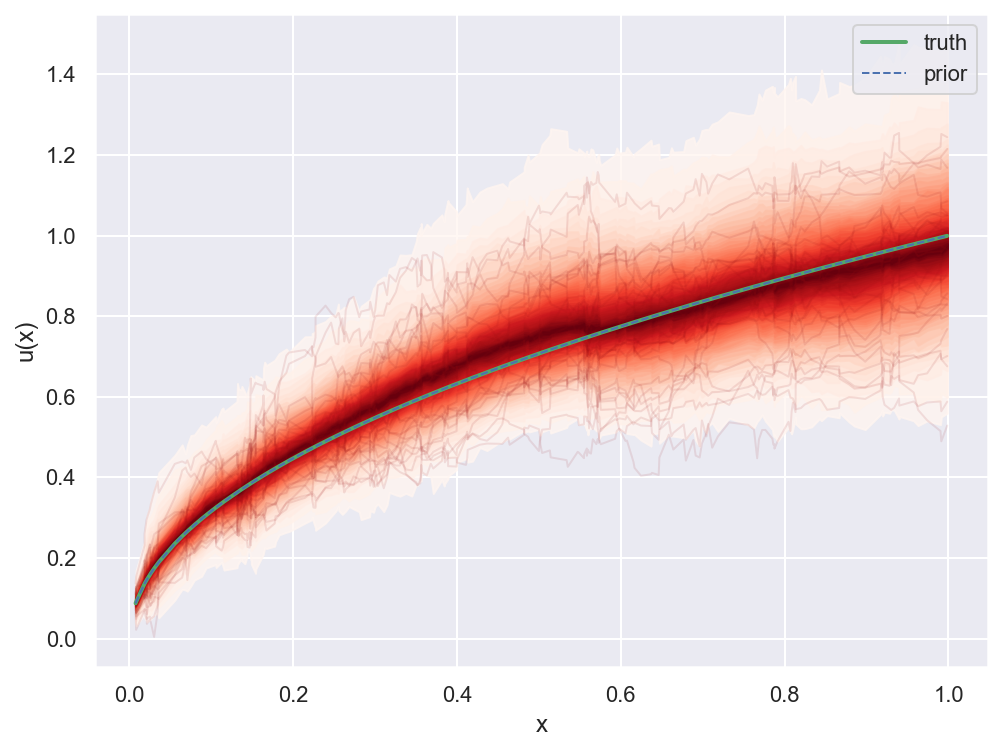

In [259]:
fig, ax = plt.subplots(figsize=(8, 6))
plot_gp_dist(ax, samples, x_sorted)
ax.plot(x_sorted, u_data(x_sorted, theta_data), lw=2, color='C2', label="truth")
ax.plot(x_sorted, u_model(x_sorted, theta_model), lw=1, ls='--', color='C0', label="prior")
ax.set_xlabel("x")
ax.set_ylabel("u(x)")
ax.legend();